# 1
Загрузить titanic.csv. Нарисовать диаграммы (гистограммы/круговые/...), по которым можно будет сравнить 1) вероятность выжить для мужчин и женщин, 2) вероятность выжить для пассажиров разных социально-экономических классов (Pclass), 3) стоимость билета в зависимости от социально-экономического класса. Написать, что вам удалось узнать из этих диаграмм (например, «для пассажира 1 класса вероятность выжить составила XX% и оказалась выше, чем у пассажира 2 класса (YY%)»; чем больше информации вы сможете извлечь из диаграмм, тем лучше)

In [68]:
import numpy as np
import pandas
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import classification_report, f1_score
import matplotlib
import seaborn as sns
matplotlib.style.use('ggplot')

%matplotlib inline

In [69]:
df = pandas.read_csv('titanic.csv', index_col='PassengerId')

Верхушка таблицы

In [70]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Общие статистики

In [71]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Абсолютные частоты
Построим простые распределения значений по признакам, чтобы получить общее представление о данных.

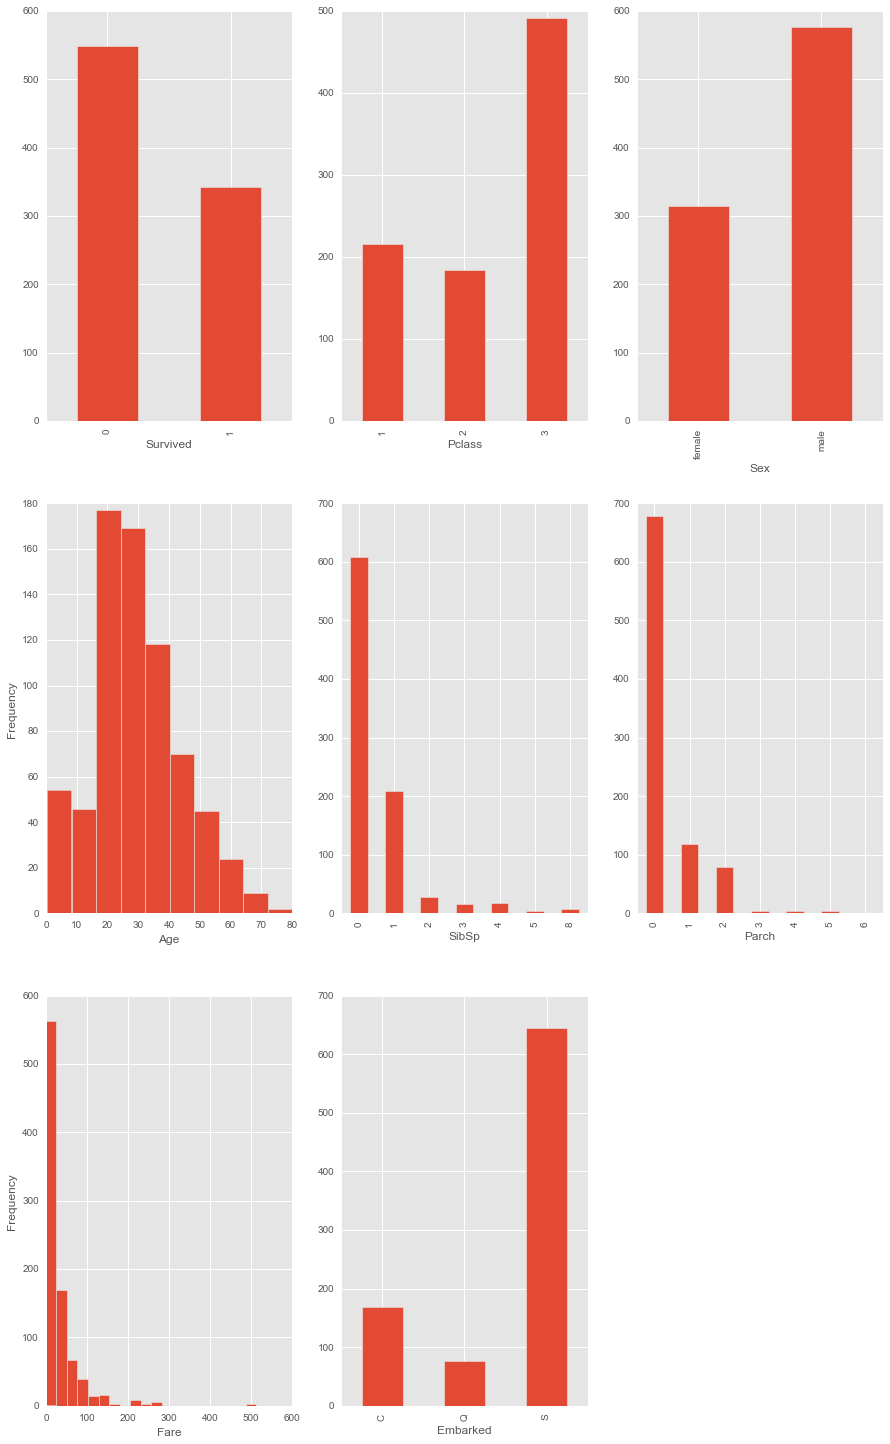

In [72]:
plt.subplot(3,3,1)
df.groupby('Survived').size().plot(kind='bar', figsize=(15,25))
plt.subplot(3,3,2)
df.groupby('Pclass').size().plot(kind='bar')
plt.subplot(3,3,3)
df.groupby('Sex').size().plot(kind='bar')
plt.subplot(3,3,4)
df['Age'].plot(kind='hist', bins=10).set_xlabel('Age')
plt.subplot(3,3,5)
df.groupby('SibSp').size().plot(kind='bar')
plt.subplot(3,3,6)
df.groupby('Parch').size().plot(kind='bar')
plt.subplot(3,3,7)
df['Fare'].plot(kind='hist', bins=20).set_xlabel('Fare')
plt.subplot(3,3,8)
df.groupby('Embarked').size().plot(kind='bar')


In [73]:
df.loc[lambda df: df['Fare'] > 300, :]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C


По стоимости билета есть явные аутлаеры – они нивелируются, когда мы позже разделим стоимость на кванторы. Пассажиров с 3 родственниками первого порядка и больше (мать, отец, дети) или 5 родственниками второго порядка или больше (муж, жена, братья, сестры) гораздо меньше, чем остальных, но непонятно, нужно ли их считать аутлаерами (распределение приближается к 0 относительно гладко).

### Чистим данные
Посмотрим на пустые ячейки.

In [74]:
for column in df:
    null = df[column].isnull().sum()
    print('В колонке {} {} пустых ячеек'.format(column, null))

В колонке Survived 0 пустых ячеек
В колонке Pclass 0 пустых ячеек
В колонке Name 0 пустых ячеек
В колонке Sex 0 пустых ячеек
В колонке Age 177 пустых ячеек
В колонке SibSp 0 пустых ячеек
В колонке Parch 0 пустых ячеек
В колонке Ticket 0 пустых ячеек
В колонке Fare 0 пустых ячеек
В колонке Cabin 687 пустых ячеек
В колонке Embarked 2 пустых ячеек


У многих не указан возраст и каюта. У двух пассажиров не указан порт посадки.

Уберем из таблицы имя, так как оно не несет почти никакой информации для нашей задачи. Билет тоже не будем использовать, потому что, кажется, там какая-то разнородная информация, и непонятно, какую пользу это может нам принести. Пол заменим на численную переменную. Не будем рассматривать каюту, потому что слишком много пустых ячеек (возможно, первая буква в названии - палуба, и тогда можно было бы предположить зависимость; но каюта указана только у 25% пассажиров). Пустые ячейки в колонке возраста заменим на медиану возраста (хотя в тьюториале на kaggle заменяют на рандомные значения из нормального распределения, что, конечно, правильнее), а в колонке порта посадки - на самые частые. Потом заменим порт на численную переменную.

In [75]:
new_sex = pandas.get_dummies(df['Sex'], drop_first=True)
new_df = pandas.concat([df, new_sex], axis = 1)
new_df['Age'].fillna(new_df['Age'].median(), inplace=True)
new_df['Embarked'].fillna(new_df['Embarked'].mode()[0], inplace=True)
new_port = pandas.get_dummies(df['Embarked'])
new_df = pandas.concat([new_df, new_port], axis = 1)
new_df.drop(['Name', 'Ticket', 'Cabin', 'Sex', 'Embarked'], axis=1, inplace=True)
new_df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,C,Q,S
PassengerId,,,,,,,,,,
1,0,3,22.0,1,0,7.2500,1,0,0,1
2,1,1,38.0,1,0,71.2833,0,1,0,0
3,1,3,26.0,0,0,7.9250,0,0,0,1
4,1,1,35.0,1,0,53.1000,0,0,0,1
5,0,3,35.0,0,0,8.0500,1,0,0,1


Посмотрим на средние показатели у выживших и невыживших.

In [76]:
pandas.pivot_table(new_df, index='Survived')

,Age,C,Fare,Parch,Pclass,Q,S,SibSp,male
Survived,,,,,,,,,
0,30.028233,0.136612,22.117887,0.329690,2.531876,0.085610,0.777778,0.553734,0.852459
1,28.291433,0.271930,48.395408,0.464912,1.950292,0.087719,0.634503,0.473684,0.318713


Явно видно, что среди выживших больше пассажиров с более дорогим билетом и с билтом лучшего класса, с родственниками первого порядка и женщин. Пассажиры, зашедшие в Шербурге (C) выживали чаще, - скорее всего это коррелирует с ценой билета/классом. Еще выжившее немного моложе, среди них меньше зашедших в Саутгемптоне (S), и у них меньше родственников второго порядка. Посмотрим на графики.

### Класс и родственники

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64
Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64
SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64


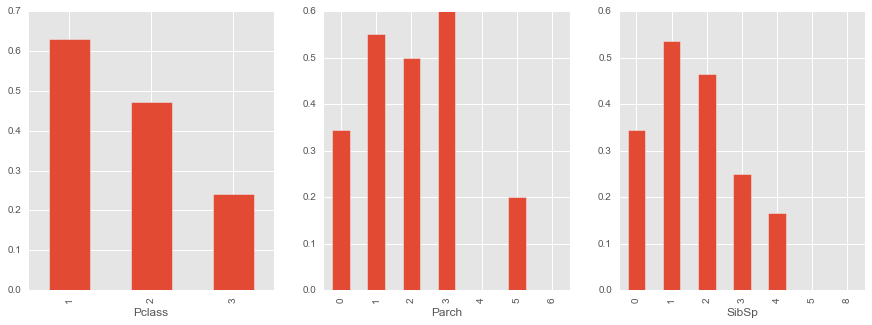

In [77]:
plt.subplot(1,3,1)
pandas.pivot_table(new_df, values='Survived', index='Pclass').plot(kind='bar', figsize=(15,5))
plt.subplot(1,3,2)
pandas.pivot_table(new_df, values='Survived', index='Parch').plot(kind='bar', figsize=(15,5))
plt.subplot(1,3,3)
pandas.pivot_table(new_df, values='Survived', index='SibSp').plot(kind='bar', figsize=(15,5))
print(pandas.pivot_table(new_df, values='Survived', index='Pclass'))
print(pandas.pivot_table(new_df, values='Survived', index='Parch'))
print(pandas.pivot_table(new_df, values='Survived', index='SibSp'))

Среди пассажиров первого класса вероятность выжить ~62%, второго – 47% (-15 п. п.), третьего – 24% (-38 от первого).

Ощутимое количество пассажиров имеют 0, 1, 2 родственников первого порядка (Parch), поэтому посмотрим на их вероятности. У пассажиров без таких родственников вероятность выжить – 34%, с 1 – 55% (+21), с 2 – 50% (+16). Лучше плавать с детьми или родителями.

Ощутимое количество пассажиров имеют 0, 1 родственников второго порядка (SibSp), поэтому посмотрим на их вероятности. У пассажиров без таких родственников вероятность выжить – 34%, с 1 – 54% (+20). C братьями, сестрами и супругами тоже плавать лучше.

### Порт посадки

C
0    0.344398
1    0.553571
Name: Survived, dtype: float64
Q
0    0.383292
1    0.389610
Name: Survived, dtype: float64
S
0    0.506073
1    0.336957
Name: Survived, dtype: float64


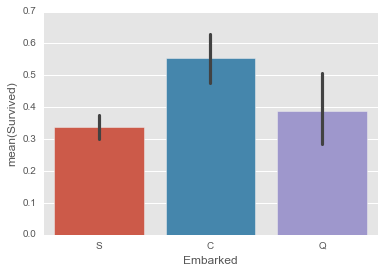

In [78]:
sns.barplot(x = 'Embarked', y='Survived', data=df)
print(pandas.pivot_table(new_df, values='Survived', index='C'))
print(pandas.pivot_table(new_df, values='Survived', index='Q'))
print(pandas.pivot_table(new_df, values='Survived', index='S'))

У зашедших в Шербурге вероятность выжить выше всех – 55%, в Квинстауне – 40% (-15), в Саутгемптоне – 37% (-18). 

In [79]:
new_df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,C,Q,S
PassengerId,,,,,,,,,,
1,0,3,22.0,1,0,7.2500,1,0,0,1
2,1,1,38.0,1,0,71.2833,0,1,0,0
3,1,3,26.0,0,0,7.9250,0,0,0,1
4,1,1,35.0,1,0,53.1000,0,0,0,1
5,0,3,35.0,0,0,8.0500,1,0,0,1


### Стоимость билетов, возраст, пол

             Survived  Pclass Age  SibSp  Parch Fare  male  C  Q  S
PassengerId                                                        
1                   0       3   1      1      0    0     1  0  0  1
2                   1       1   4      1      0    6     0  1  0  0
3                   1       3   2      0      0    1     0  0  0  1
4                   1       1   4      1      0    5     0  0  0  1
5                   0       3   4      0      0    1     1  0  0  1
Fare
0    0.207143
1    0.200000
2    0.316327
3    0.406250
4    0.445312
5    0.456000
6    0.685039
Name: Survived, dtype: float64
Age
0    0.481707
1    0.328467
2    0.319328
3    0.393939
4    0.442029
5    0.371622
Name: Survived, dtype: float64
male
0    0.742038
1    0.188908
Name: Survived, dtype: float64


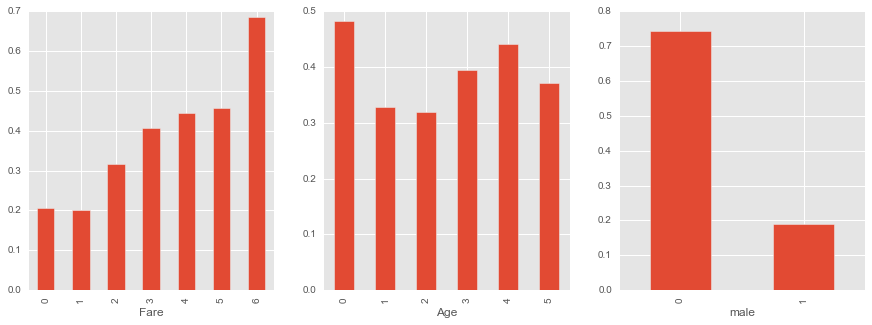

In [80]:
# как в kaggle, поделим стоимость билета и возраст на квантили
new_df['Fare'] = pandas.qcut(new_df['Fare'], 7, labels=[0, 1, 2, 3, 4, 5, 6])
new_df['Age'] = pandas.qcut(new_df['Age'], 6, labels=[0, 1, 2, 3, 4, 5])
print(new_df.head())

plt.subplot(1,3,1)
pandas.pivot_table(new_df, values='Survived', index='Fare').plot(kind='bar', figsize=(15,5))
plt.subplot(1,3,2)
pandas.pivot_table(new_df, values='Survived', index='Age').plot(kind='bar', figsize=(15,5))
plt.subplot(1,3,3)
pandas.pivot_table(new_df, values='Survived', index='male').plot(kind='bar', figsize=(15,5))

print(pandas.pivot_table(new_df, values='Survived', index='Fare'))
print(pandas.pivot_table(new_df, values='Survived', index='Age'))
print(pandas.pivot_table(new_df, values='Survived', index='male'))

Вероятность выжить сильно отличается по стоимости билетов: в первом и втором квантиле она всего 20%, в третьем-шестом она постепенно возрастает от 32% (+12) до 46% (+26), в седьмом она самая высокая – 68% (+48).

Какой-то устойчивой корреляции выживаемости с возрастом не видно. Только в первом квантиле по возрасту она самая высокая – 48%. Хорошо быть молодым.

И женщиной. У них вероятность выжить гораздо больше, чем у мужчин (74% против 19%, -55).

### Стоимость билета в зависимости от социально-экономического класса

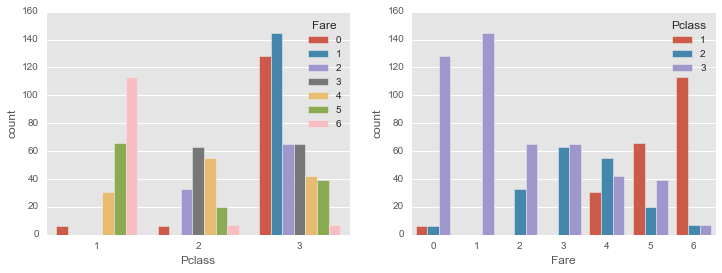

In [81]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 4)
plt.subplot(1,2,1)
sns.countplot(x='Pclass', hue='Fare', data=new_df)
plt.subplot(1,2,2)
sns.countplot(x='Fare', hue='Pclass', data=new_df)

Хммм, забавно. В первом и втором классе есть немного самых дешевых билетов. Но в основном в первом, конечно, билеты из 4, 5, 6 квантилей – самые дорогие. А в третьем классе есть все, хотя больше всего самых дешевых.

# 2 
А теперь нарисуем два предиктора на одной диаграмме. Нарисовать гистограмму, описывающую среднюю вероятность выжить в зависимости от пола и соц. статуса. Например, это может быть гистограмма с тремя группами столбцов (разделение по соц.статусу), в которой высота столбца соответствует среднему числу выживших, а цвет столбца обозначает пол пассажиров. Снова интерпретировать результаты (Например, какова вероятность выжить женщине из первого класса?). Записать любые два утверждения в виде формул (нужно вспомнить, что такое совместная и/или условная вероятность).




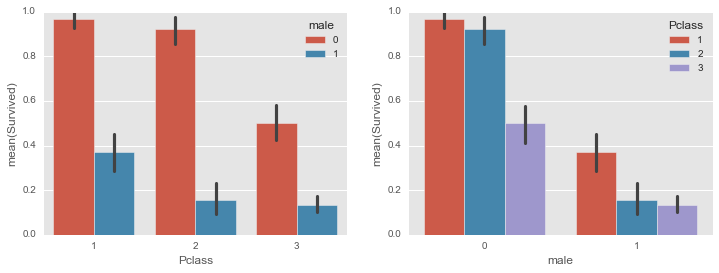

In [82]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 4)
plt.subplot(1,2,1)
sns.barplot(x='Pclass', y='Survived', hue='male', data=new_df)
plt.subplot(1,2,2)
sns.barplot(x='male', y='Survived', hue='Pclass', data=new_df)

Да, лучше всего быть женщиной первого класса – они почти все выжили (>95%).

S – пассажир выжил. F1, F3 – женщины первого и третьего класса. 
Вероятность выжить у женщин первого класса почти в два раза больше, чем у женщин третьего класса: P(S|F1) ~ 2 * P(S|F3).
Вероятность выжить у мужщин любого класса ниже, чем у женщин любого класса: ∀n=1,2,3, ∀m=1,2,3, P(S|Mn) < P (S|Fm).

# 3
Почистите данные так, как считаете нужным (не забывайте про коварную переменную Sex; постарайтесь не удалять строки). Extra: сможете ли вы использовать не 4 столбца, а больше? Например, кажется, что если ребёнок ехал с братом/сестрой, то их не разлучат, а посадят вместе в шлюпку, и они выживут...

Сделано в п. 1.


In [83]:
new_df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,C,Q,S
PassengerId,,,,,,,,,,
1,0,3,1,1,0,0,1,0,0,1
2,1,1,4,1,0,6,0,1,0,0
3,1,3,2,0,0,1,0,0,0,1
4,1,1,4,1,0,5,0,0,0,1
5,0,3,4,0,0,1,1,0,0,1


# 4
Разделить данные на обучающую и проверочную выборки (или использовать кросс-валидацию). Будем строить дерево решений. Нужно выбрать параметр модели, который, на ваш взгляд, может повлиять на результат, и выбрать для него возможные значения. Прокомментировать свой выбор. Изменяя в цикле значения параметра, посчитать для каждого случая точноть, полноту, F-меру (может быть, другие метрики?). Изобразить результаты на диаграмме/-ах. Интерпретировать результаты. Нарисовать лучшее дерево.

Extra: варьировать не в цикле, а использовать grid search.
Super–duper-Extra: построить ROC-кривую и написать свою интерпретацию того, что эта диаграмма говорит о модели.

In [84]:
x = new_df[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'male', 'C', 'Q', 'S']]
y = new_df['Survived']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

Возьмем параметр max_features (сколько фичей учитывать при принятии решения) и min_samples_split (минимальный размер ячейки, которую еще можно расщепить). Есть вопросы, потому что в документации к DecisionTreeClassifier такие штуки для max_features: 
    If “auto”, then max_features=sqrt(n_features).
    If “sqrt”, then max_features=sqrt(n_features).
То есть получается, между auto и sqrt нет никакой разницы? Ладно, запихнем всё в массив.

Best precision: 0.8668569208701888
Best max_features: 6
Best min_samples_split: 100


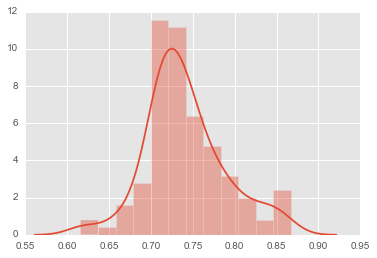

In [85]:
from sklearn import grid_search

parameters = {'max_features': ['log2', 'sqrt', 'auto', None, 1, 2, 3, 4, 5, 6, 7, 8],
              'min_samples_split' :  [2, 4, 10, 12, 16, 20, 40, 80, 100, 150]}

tree = DecisionTreeClassifier()
gs = grid_search.GridSearchCV(tree, parameters, scoring='precision')
gs.fit(x_train, y_train)
print('Best precision: {}'.format(gs.best_score_))
print('Best max_features: {}'.format(gs.best_estimator_.max_features))
print('Best min_samples_split: {}'.format(gs.best_estimator_.min_samples_split))

scores = [element.mean_validation_score for element in gs.grid_scores_]
sns.distplot(scores)

Best recall: 0.6956216414264778
Best max_features: 4
Best min_samples_split: 10


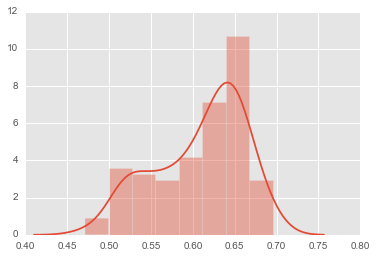

In [86]:
gs = grid_search.GridSearchCV(tree, parameters, scoring='recall')
gs.fit(x_train, y_train)
print('Best recall: {}'.format(gs.best_score_))
print('Best max_features: {}'.format(gs.best_estimator_.max_features))
print('Best min_samples_split: {}'.format(gs.best_estimator_.min_samples_split))

scores = [element.mean_validation_score for element in gs.grid_scores_]
sns.distplot(scores)

Best f1: 0.7274808945845086
Best max_features: 7
Best min_samples_split: 20


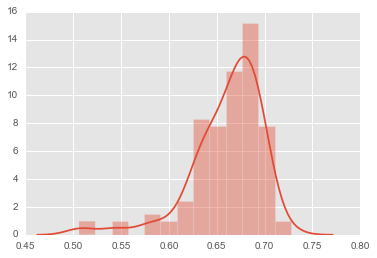

In [87]:
gs = grid_search.GridSearchCV(tree, parameters, scoring='f1')
gs.fit(x_train, y_train)
print('Best f1: {}'.format(gs.best_score_))
print('Best max_features: {}'.format(gs.best_estimator_.max_features))
print('Best min_samples_split: {}'.format(gs.best_estimator_.min_samples_split))

scores = [element.mean_validation_score for element in gs.grid_scores_]
sns.distplot(scores)

Можно получить довольно высокую точность (до 98%), но с такими параметрами будет низкая полнота. Для конечной модели возьмем лучшие параметры по F-мере: в последней итерации они были max_features=7, min_samples_split=20 (а вообще колебания очень сильные). То есть при ветвлении мы смотрим на 2 фичи и ячейки меньше 80 вхождений не ветвим.

In [88]:
best_tree = DecisionTreeClassifier(max_features=gs.best_estimator_.max_features, 
                                   min_samples_split=gs.best_estimator_.min_samples_split)
best_tree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=7, max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [89]:
y_pred = best_tree.predict(x_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.83      0.88      0.85       113
          1       0.78      0.68      0.73        66

avg / total       0.81      0.81      0.81       179



У погибших меньше точность, но больше полнота, у выживших – больше точность, но меньше полнота. То есть определяются пости все погибшие, и те выжившие, которые размечаются, размечаются более или менее правильно. Средняя F-мера ничего такая – в районе 80%.

In [90]:
import graphviz
from sklearn.tree import export_graphviz

export_graphviz(best_tree, out_file='best_tree.dot', 
                feature_names=['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'male', 'C', 'Q', 'S'])
graphviz.Source(open('best_tree.dot').read())

RuntimeError: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' path

Никак у меня не получилось нарисовать дерево :(

### ROC-curve

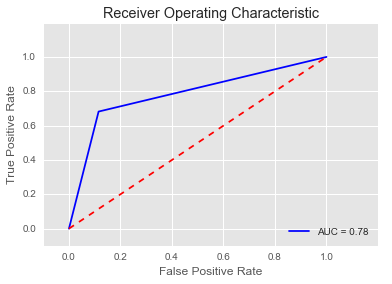

In [91]:
from sklearn.metrics import roc_curve, auc, confusion_matrix

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Оно же не так должно выглядить? Я начала копать, что не так, и вроде докопалась до того, что классификатор должен быть ранжирующим (Naive Bayes, Logit). У меня такое ощущение, что Decision Tree – не ранжирующий? Но всё равно непонятно, потому что функция roc_curve, по идее, должна воспринимать ей заданные массивы как отранжированные и шагать по ним?

# 5 
Проделать аналогичные операции для модели Random Forest. Сравнить результаты.

Best precision: 0.8492301341863849
Best max_features: 8
Best min_samples_split: 100


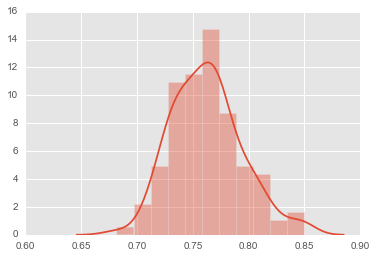

In [92]:
forest = RandomForestClassifier()
gs = grid_search.GridSearchCV(forest, parameters, scoring='precision')
gs.fit(x_train, y_train)
print('Best precision: {}'.format(gs.best_score_))
print('Best max_features: {}'.format(gs.best_estimator_.max_features))
print('Best min_samples_split: {}'.format(gs.best_estimator_.min_samples_split))

scores = [element.mean_validation_score for element in gs.grid_scores_]
sns.distplot(scores)

Best recall: 0.7173302393746946
Best max_features: 7
Best min_samples_split: 2


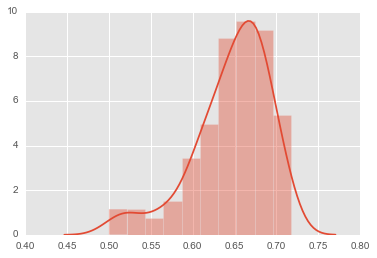

In [93]:
gs = grid_search.GridSearchCV(forest, parameters, scoring='recall')
gs.fit(x_train, y_train)
print('Best recall: {}'.format(gs.best_score_))
print('Best max_features: {}'.format(gs.best_estimator_.max_features))
print('Best min_samples_split: {}'.format(gs.best_estimator_.min_samples_split))

scores = [element.mean_validation_score for element in gs.grid_scores_]
sns.distplot(scores)

Best f1: 0.7330783170260221
Best max_features: sqrt
Best min_samples_split: 10


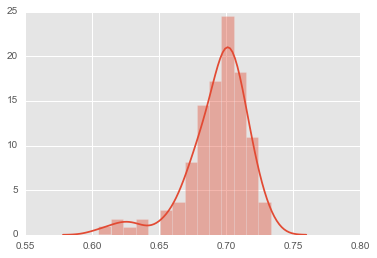

In [94]:
gs = grid_search.GridSearchCV(forest, parameters, scoring='f1')
gs.fit(x_train, y_train)
print('Best f1: {}'.format(gs.best_score_))
print('Best max_features: {}'.format(gs.best_estimator_.max_features))
print('Best min_samples_split: {}'.format(gs.best_estimator_.min_samples_split))

scores = [element.mean_validation_score for element in gs.grid_scores_]
sns.distplot(scores)

In [95]:
best_forest = RandomForestClassifier(max_features=gs.best_estimator_.max_features,
                                     min_samples_split=gs.best_estimator_.min_samples_split)
best_forest.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [96]:
y_pred = best_forest.predict(x_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.84      0.93      0.88       113
          1       0.85      0.70      0.77        66

avg / total       0.84      0.84      0.84       179



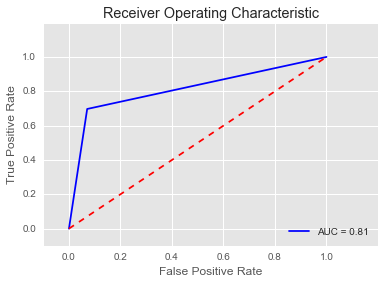

In [97]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [ ]:
Ну, вроде здесь F-мера получше...